In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from imgcube.cube import imagecube
import numpy as np

In [21]:
# Load data and calculate RMS from Jy/beam > K.
cube = imagecube('../data/TWHya.290GHz.40mas.fits', clip=1.0, kelvin=True)
rms = cube._jybeam_to_Tb_RJ(1.9e-5)
print(rms)

0.282487781240032


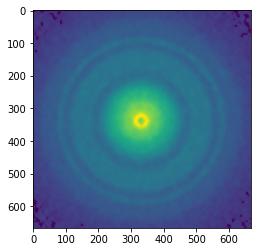

In [20]:
# Check data.
fig, ax = plt.subplots()
ax.imshow(cube.data)

In [4]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

# We can pre-compute the meshgrid and pre-flatten the grids
np.random.seed(1234)
X, Y = np.meshgrid(cube.xaxis, cube.yaxis)
X = X.flatten()
Y = Y.flatten()
y = np.array(cube.data.flatten(), dtype=np.float64)

# Randomly subsample
mask = (y > 0.0) & (np.random.rand(len(y)) < 0.05)
X = X[mask]
Y = Y[mask]

# We'll fit in the log since it must always be positive
y = np.log(y[mask])

# Copied from https://github.com/richteague/imgcube/blob/master/imgcube/cube.py
# and converted to theano instead of numpy
def _deproject_coords(x, y, inc):
    return x, y / tt.cos(inc)

def _rotate_coords(x, y, PA):
    x_rot = x * tt.cos(PA) - y * tt.sin(PA)
    y_rot = y * tt.cos(PA) + x * tt.sin(PA)
    return x_rot, y_rot

def _get_cart_sky_coords(x0, y0):
    return X - x0, Y - y0

def _get_midplane_cart_coords(x0, y0, inc, PA):
    x_sky, y_sky = _get_cart_sky_coords(x0, y0)
    x_rot, y_rot = _rotate_coords(y_sky, x_sky, -PA)
    return _deproject_coords(x_rot, y_rot, inc)

def _get_midplane_polar_coords(x0, y0, inc, PA):
    x_mid, y_mid = _get_midplane_cart_coords(x0, y0, inc, PA)
    return tt.sqrt(y_mid**2 + x_mid**2), tt.arctan2(y_mid, x_mid)

In [5]:
with pm.Model() as model:
    
    # Parameters
    x0 = pm.Normal("x0", mu=0.0, sd=0.1)
    y0 = pm.Normal("y0", mu=0.0, sd=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=0.5*np.pi)
    pa_deg = pm.Normal("pa_deg", mu=151.11, sd=np.sqrt(1.5))
    pa = pa_deg * np.pi / 180.0
    mu = pm.Normal("mu", mu=np.mean(y), sd=100.0)
    slope = pm.Normal("slope", mu=0.0, sd=100.0)
    
    # Get the projected coordinates
    x_mid, y_mid = _get_midplane_cart_coords(x0, y0, inc, pa)
    r = tt.sqrt(y_mid**2 + x_mid**2)
    inds = tt.argsort(r)
    
    # Sort by radius
    r_sort = r[inds]
    y_sort = tt.as_tensor_variable(y)[inds]
    
    # Jitter & GP parameters
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=10)
    logw0_guess = np.log(2*np.pi/0.1)
    logtau = pm.Bound(pm.Normal, upper=0.0)(
        "logtau", mu=np.log(2*np.pi)-logw0_guess, sd=10)
    logw0 = np.log(2*np.pi) - logtau

    # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
    # S_0 directly because this removes some of the degeneracies between
    # S_0 and omega_0
    logpower = pm.Normal("logpower",
                         mu=np.log(np.var(y))+4*logw0_guess,
                         sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

    # Setup the GP
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, r_sort, tt.exp(0.5*logs2) + np.zeros_like(y), J=2)
    
    # Compute the mean model
    line = mu + slope * r_sort
    
    # Compute the GP likelihood and predictions
    pm.Potential("loglike", gp.log_likelihood(y_sort - line))
    gp_pred = gp.predict() + line
    
    # Optimize to find the MAP
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, vars=[logs2, mu, slope])
    map_soln = xo.optimize(map_soln, vars=[x0, y0])
    map_soln = xo.optimize(map_soln, vars=[inc, pa_deg])
    map_soln = xo.optimize(map_soln, vars=[logs2, logpower, logtau])
    map_soln = xo.optimize(map_soln)

optimizing logp for variables: ['slope', 'mu', 'logs2']
message: Optimization terminated successfully.
logp: -3159.520675174555 -> 6233.223018167476
optimizing logp for variables: ['y0', 'x0']
message: Desired error not necessarily achieved due to precision loss.
logp: 6233.223018167476 -> 6257.437559140594
optimizing logp for variables: ['pa_deg', 'inc_interval__']
message: Optimization terminated successfully.
logp: 6257.437559140594 -> 9687.253895469239
optimizing logp for variables: ['logtau_upperbound__', 'logpower', 'logs2']
message: Optimization terminated successfully.
logp: 9687.253895469239 -> 14548.899535401368
optimizing logp for variables: ['logpower', 'logtau_upperbound__', 'logs2', 'slope', 'mu', 'pa_deg', 'inc_interval__', 'y0', 'x0']
message: Desired error not necessarily achieved due to precision loss.
logp: 14548.899535401368 -> 16440.12770615424


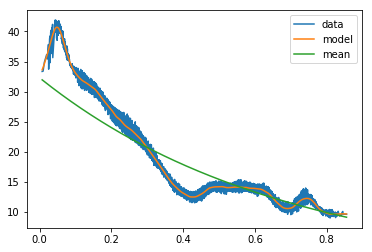

In [6]:
with model:
    a, b, c, d = xo.utils.eval_in_model([r_sort, y_sort, gp_pred, line], map_soln)
    
plt.plot(a, np.exp(b), label="data")
plt.plot(a, np.exp(c), label="model")
plt.plot(a, np.exp(d), label="mean")
plt.legend()

In [9]:
t0 = time.time()
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)
print(time.time() - t0)

Sampling 4 chains: 100%|██████████| 808/808 [00:39<00:00, 20.57draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logtau, logs2, slope, mu, pa_deg, inc, y0, x0]
Sampling 4 chains: 100%|██████████| 8000/8000 [05:08<00:00, 25.94draws/s]


865.0313990116119


In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
x0,0.008371,0.000168,0.000002,0.008034,0.008692,7556.970306,0.999930
y0,0.007113,0.000173,0.000002,0.006795,0.007470,6862.937587,0.999822
pa_deg,151.009421,1.212009,0.012600,148.632130,153.341892,7259.664065,0.999808
mu,3.371446,0.267651,0.003859,2.766349,3.836342,4127.125659,1.000186
slope,-1.287509,0.489664,0.007243,-2.210236,-0.232608,4374.215935,1.000147
logs2,-13.946043,0.031142,0.000374,-14.006483,-13.883605,7189.893073,0.999853
logpower,5.035681,0.199906,0.002329,4.654498,5.423939,6216.869092,1.000311
inc,0.077279,0.008248,0.000111,0.060740,0.092917,6507.768686,1.000142
logtau,-0.688056,0.303020,0.006688,-1.178625,-0.058444,2081.902169,1.000935
logS0,-5.068049,1.171160,0.026245,-6.966568,-2.668881,2044.788957,1.000802


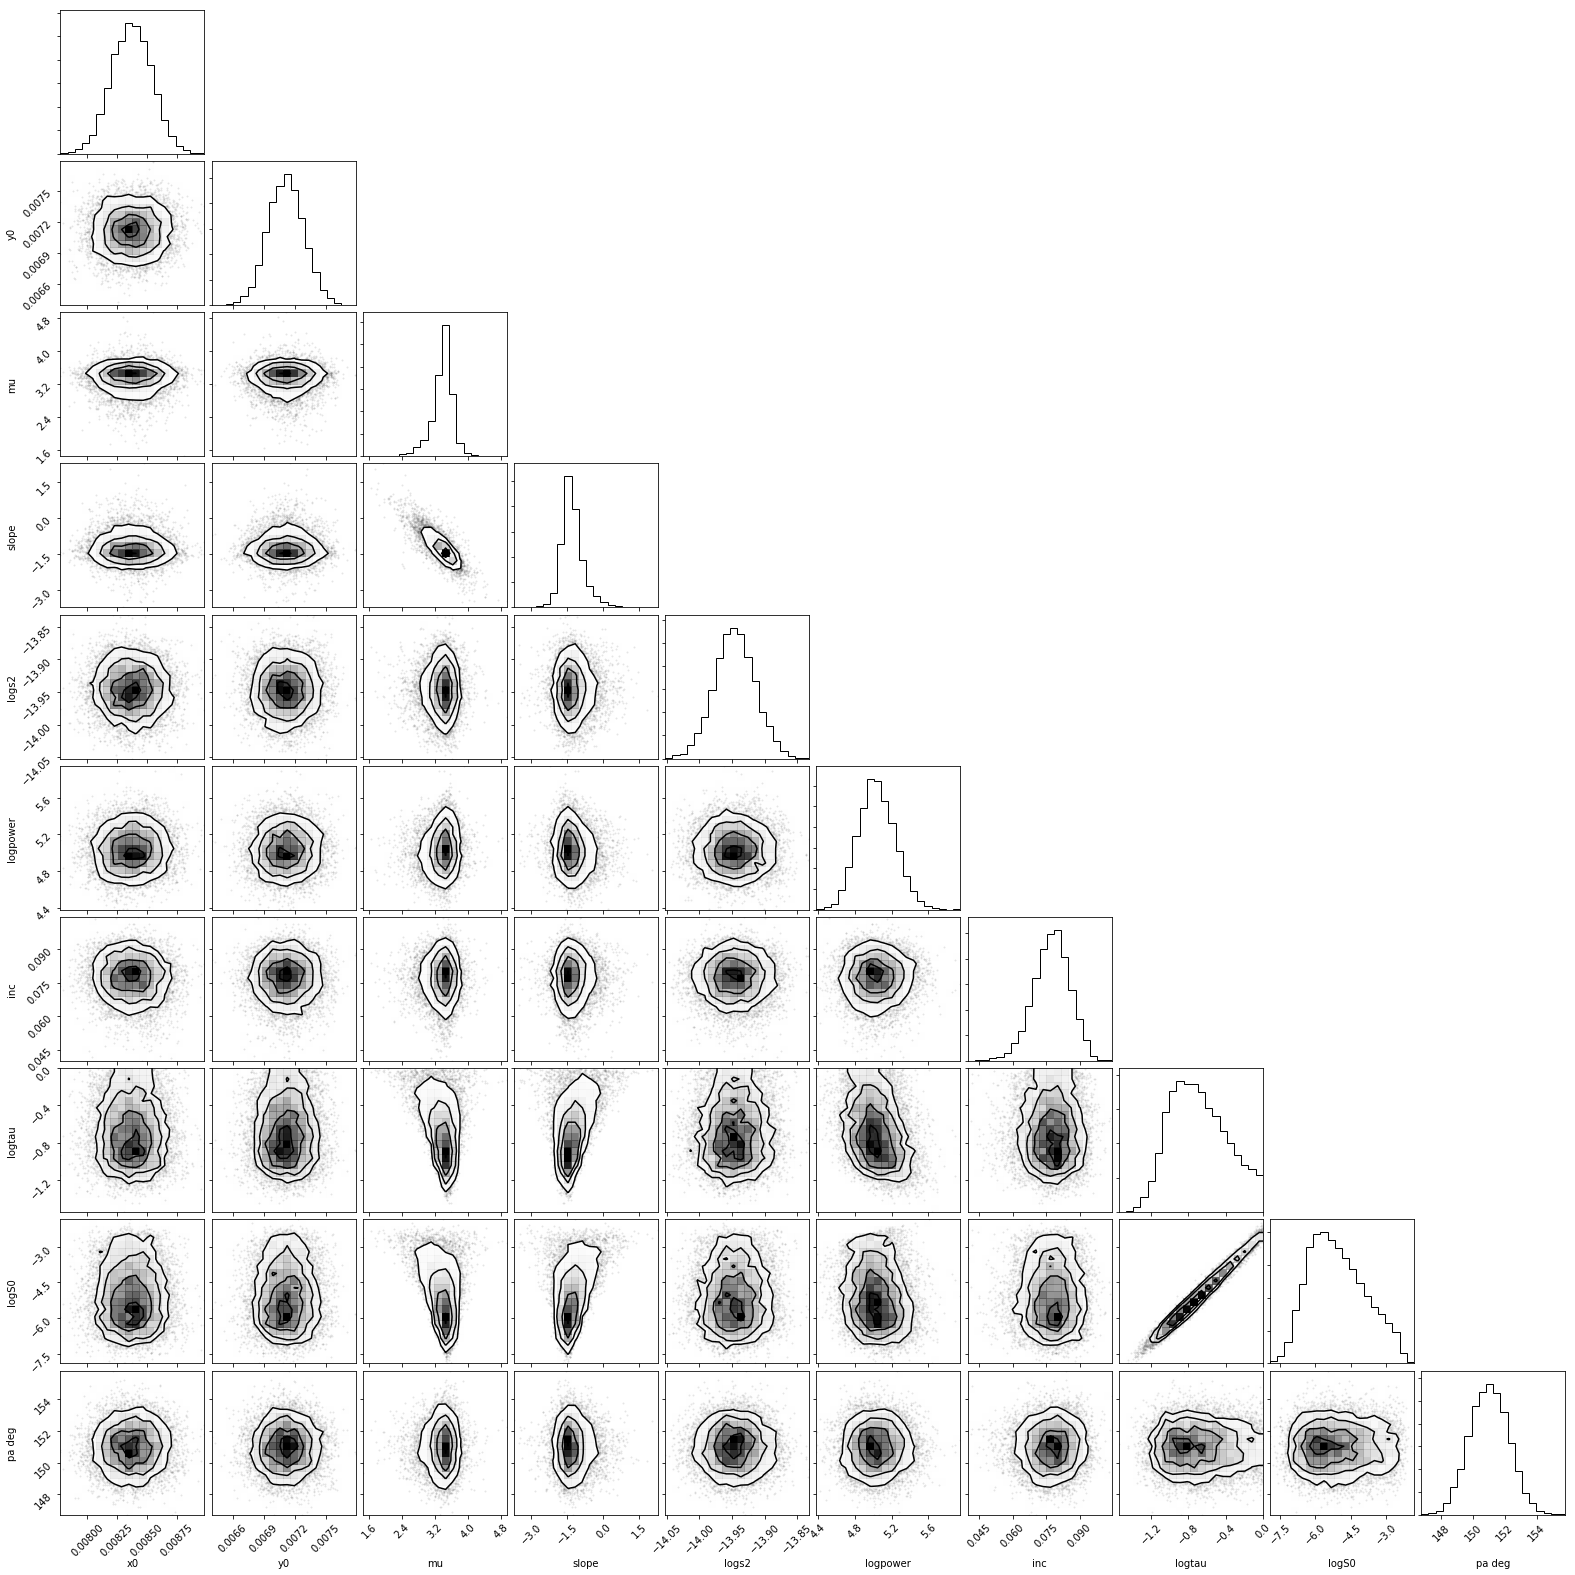

In [12]:
import corner
samples = pm.trace_to_dataframe(trace)
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", " ")] = samples[k]
        del samples[k]
corner.corner(samples);

Text(0.5, 0, 'inclination [deg]')

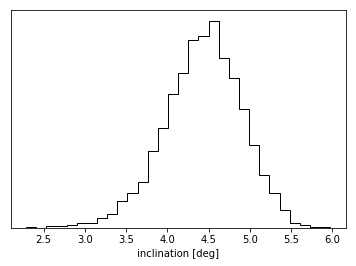

In [15]:
inc_deg = np.degrees(trace["inc"])
plt.hist(inc_deg, 30, color="k", histtype="step")
plt.yticks([])
plt.xlabel("inclination [deg]")

In [7]:
a = tt.scalar('a')

In [18]:
from prettyplots.prettyplots import percentiles_to_errors

print(percentiles_to_errors(np.percentile(inc_deg, [16, 50, 84])))

[4.446393   0.47489593 0.44302219]


In [10]:
865 / 60.

14.416666666666666